# Forecasting the ENSO index 

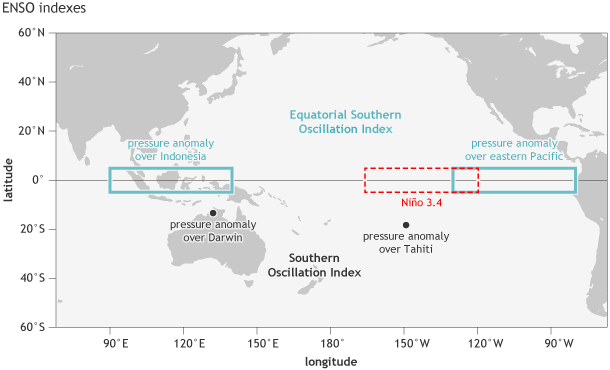

In [1]:
en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from utils.utils import get_area_mean, get_enso_mean, r_squared
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
import tensorflow as tf
from models.keras_models import CNNenso
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
X_ds = xr.open_dataset('./data/ENSO/train.nc')
y_array = np.load('./data/ENSO/train.npy')

In [4]:
X_ds

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 72, time: 708)
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 ... 75.0 80.0 85.0 90.0
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 ... 1758-12-16
Data variables:
    tas      (time, lat, lon) float64 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  6

In [5]:
X_ds['tas']

<xarray.DataArray 'tas' (time: 708, lat: 37, lon: 72)>
[1886112 values with dtype=float64]
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 ... 75.0 80.0 85.0 90.0
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 ... 1758-12-16

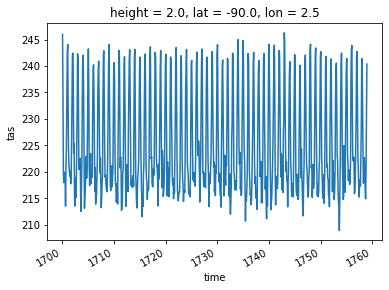

In [6]:
X_ds['tas'].isel(lat=0, lon=0).plot()

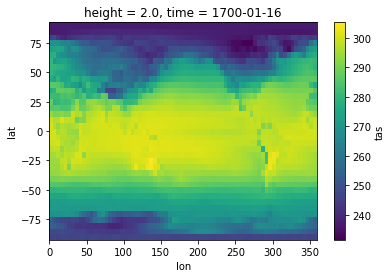

In [7]:
X_ds['tas'].isel(time=0).plot()

In [11]:
len(X_ds['tas'][:, 0, 0])

708

In [13]:
y_array.shape

(708,)

In [14]:
X_ds.n_lookahead

6

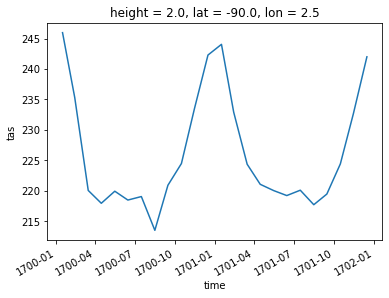

In [17]:
X_ds['tas'][:24, 0, 0].plot()

In [20]:
X_enso = get_enso_mean(X_ds['tas'])

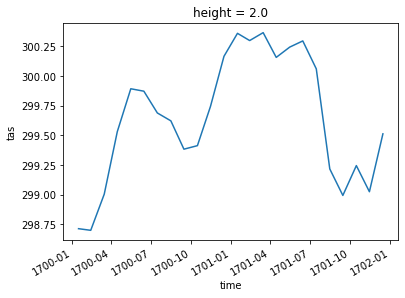

In [25]:
X_enso[:24].plot()

In [45]:
len(y_array)

708

In [47]:
y_array

array([299.68909098, 299.62266947, 299.38398844, 299.41364237,
       299.74432983, 300.16651611, 300.3601237 , 300.29920146,
       300.36586202, 300.1573995 , 300.24405314, 300.29606527,
       300.06072388, 299.21739705, 298.99423625, 299.24555969,
       299.02548319, 299.5132253 , 299.44878337, 299.18350728,
       299.10292257, 299.31360067, 299.30114441, 299.23499146,
       298.73236389, 298.18153178, 297.7196106 , 297.89548136,
       298.08258464, 298.2351298 , 298.29011841, 298.43161723,
       299.01617228, 299.26343892, 299.67506612, 299.88393555,
       299.80882874, 299.32874349, 299.00979818, 299.12949015,
       299.688679  , 299.91440837, 300.26181742, 300.25551147,
       300.16679484, 300.05690104, 300.17946676, 299.82577922,
       299.48422546, 298.83221029, 298.39238485, 298.16024679,
       298.51611837, 298.88151347, 298.73832804, 299.08477071,
       299.24384054, 299.32169291, 299.53120422, 299.8489919 ,
       299.66968587, 299.16219788, 299.04586995, 299.06

In [53]:
get_enso_mean(X_ds['tas'])

<xarray.DataArray 'tas' (time: 708)>
array([298.71399028, 298.70027466, 299.00478007, 299.53160095,
       299.89300435, 299.87256571, 299.68909098, 299.62266947,
       299.38398844, 299.41364237, 299.74432983, 300.16651611,
       300.3601237 , 300.29920146, 300.36586202, 300.1573995 ,
       300.24405314, 300.29606527, 300.06072388, 299.21739705,
       298.99423625, 299.24555969, 299.02548319, 299.5132253 ,
       299.44878337, 299.18350728, 299.10292257, 299.31360067,
       299.30114441, 299.23499146, 298.73236389, 298.18153178,
       297.7196106 , 297.89548136, 298.08258464, 298.2351298 ,
       298.29011841, 298.43161723, 299.01617228, 299.26343892,
       299.67506612, 299.88393555, 299.80882874, 299.32874349,
       299.00979818, 299.12949015, 299.688679  , 299.91440837,
       300.26181742, 300.25551147, 300.16679484, 300.05690104,
       300.17946676, 299.82577922, 299.48422546, 298.83221029,
       298.39238485, 298.16024679, 298.51611837, 298.88151347,
       298.73832804, 299.08477071, 299.24384054, 299.32169291,
       299.53120422, 299.8489919 , 299.66968587, 299.16219788,
       299.04586995, 299.06116943, 299.49815674, 299.53868306,
       299.75956828, 299.69691874, 299.36722005, 299.64484762,
       299.96180522, 299.56768697, 299.37949524, 298.62028402,
...
       299.49482422, 299.86304728, 299.7203776 , 299.29945984,
       299.02519531, 298.96677043, 299.45015361, 299.60267741,
       299.82493896, 299.8122701 , 299.34441732, 299.39477946,
       299.54831645, 299.57818705, 298.96306356, 298.51102905,
       298.33016866, 298.22776693, 298.60289612, 298.37449341,
       298.63748169, 298.32370605, 298.65251668, 298.77590739,
       298.74552205, 298.57170003, 298.39375305, 298.17522074,
       297.73935954, 297.51152242, 297.68424174, 297.83354594,
       297.81616007, 298.10815837, 298.6961263 , 299.09683228,
       299.54005534, 299.63271891, 299.63163452, 299.32074382,
       299.13028564, 299.08505351, 299.43274943, 299.7745697 ,
       299.93927917, 300.14278666, 300.07593689, 300.28797811,
       300.45532125, 300.35434163, 300.3817688 , 299.84756571,
       299.90789998, 299.93204651, 300.116745  , 300.45472921,
       300.68567403, 300.18753866, 299.6526001 , 299.32466024,
       299.29473165, 298.87182109, 298.04079081, 297.64092712,
       297.59451396, 297.96296488, 298.05620931, 298.14603678,
       298.23137817, 298.39725647, 298.60697734, 298.92179565,
       299.20309143, 299.25732625, 299.11979065, 298.6730835 ,
       298.20394389, 297.96294963, 298.27842   , 298.46136169])
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 ... 1758-12-16

### Simple Linear Regression

In [9]:
X1 = get_enso_mean(X_ds['tas']).values

In [62]:
X_train = X1[:708-24].reshape(-1, 1)
y_train = y_array[:708-24]
X_test = X1[708-24:].reshape(-1, 1)
y_test = y_array[708-24:]

In [63]:
lr = LinearRegression()

In [64]:
lr.fit(X_train, y_train)
print("In-sample R**2 = ", lr.score(X_train, y_train))
print("Out-of-sample R**2 = ", lr.score(X_test, y_test))

In-sample R**2 =  0.12386778041885937
Out-of-sample R**2 =  -2.2744327629101844


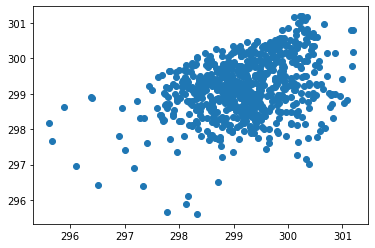

In [68]:
plt.scatter(X1, y_array)

In [87]:
kf = KFold(n_splits=6)
for i, (train_index, test_index) in enumerate(kf.split(X1)):
    print(f"Fold {i}:")
    lr = LinearRegression()
    X_train = X1[train_index].reshape(-1, 1)
    y_train = y_array[train_index]
    X_test = X1[test_index].reshape(-1, 1)
    y_test = y_array[test_index]
    lr.fit(X_train, y_train)
    print("Out-of-sample R**2 = ", lr.score(X_test, y_test))

Fold 0:
Out-of-sample R**2 =  -0.06610427216514525
Fold 1:
Out-of-sample R**2 =  0.20335571048414425
Fold 2:
Out-of-sample R**2 =  0.11742422404913466
Fold 3:
Out-of-sample R**2 =  0.04576481858022319
Fold 4:
Out-of-sample R**2 =  0.07052981091893351
Fold 5:
Out-of-sample R**2 =  -0.012274980322380502


### Lasso Regression

In [10]:
X_array = X_ds['tas'].values.reshape(708,37*72)

In [96]:
X_train = X_array[:708-24,:]
y_train = y_array[:708-24]
X_test = X_array[708-24:,:]
y_test = y_array[708-24:]

In [105]:
lasso = Lasso(alpha=0.5)

In [106]:
lasso.fit(X_train, y_train)
print("In-sample R**2 = ", lasso.score(X_train, y_train))
print("Out-of-sample R**2 = ", lasso.score(X_test, y_test))

In-sample R**2 =  0.32924362640926974
Out-of-sample R**2 =  -1.0890861170985247


In [108]:
kf = KFold(n_splits=6)
for i, (train_index, test_index) in enumerate(kf.split(X1)):
    print(f"Fold {i}:")
    lasso = Lasso(alpha=0.5)
    X_train = X_array[train_index,:]
    y_train = y_array[train_index]
    X_test = X_array[test_index,:]
    y_test = y_array[test_index]
    lasso.fit(X_train, y_train)
    print("Out-of-sample R**2 = ", lasso.score(X_test, y_test))

Fold 0:
Out-of-sample R**2 =  0.3852216949239543
Fold 1:
Out-of-sample R**2 =  0.08299606098200041
Fold 2:
Out-of-sample R**2 =  0.30125355483975835
Fold 3:
Out-of-sample R**2 =  0.25947862119552945
Fold 4:
Out-of-sample R**2 =  0.31350369437289294
Fold 5:
Out-of-sample R**2 =  0.3069851500805595


### PCA Regression

In [11]:
pca = PCA(n_components=20)
pca.fit(X_array)

PCA(n_components=20)

In [12]:
print(pca.explained_variance_ratio_)

[8.80107286e-01 4.60088923e-02 1.84598029e-02 6.27948450e-03
 5.06018019e-03 3.76304313e-03 3.44799290e-03 3.22428207e-03
 2.89274355e-03 2.14659727e-03 1.46766928e-03 1.32251939e-03
 1.24257100e-03 1.17917133e-03 1.02648134e-03 9.33445473e-04
 8.90105166e-04 8.06628914e-04 7.58646377e-04 6.49597611e-04]


In [14]:
X_rot = pca.fit_transform(X_array)
# X_rot = np.append(X_rot, np.expand_dims(X1, axis=1), axis=1)

In [131]:
X_train = X_rot[:708-24,:]
y_train = y_array[:708-24]
X_test = X_rot[708-24:,:]
y_test = y_array[708-24:]

In [132]:
lr = LinearRegression()

In [133]:
lr.fit(X_train, y_train)
print("In-sample R**2 = ", lr.score(X_train, y_train))
print("Out-of-sample R**2 = ", lr.score(X_test, y_test))

In-sample R**2 =  0.4631705372384972
Out-of-sample R**2 =  -0.91605350118104


In [134]:
kf = KFold(n_splits=6)
for i, (train_index, test_index) in enumerate(kf.split(X1)):
    print(f"Fold {i}:")
    lr = LinearRegression()
    X_train = X_rot[train_index, :]
    y_train = y_array[train_index]
    X_test = X_rot[test_index, :]
    y_test = y_array[test_index]
    lr.fit(X_train, y_train)
    print("Out-of-sample R**2 = ", lr.score(X_test, y_test))

Fold 0:
Out-of-sample R**2 =  0.38798159198138593
Fold 1:
Out-of-sample R**2 =  0.4089512899589678
Fold 2:
Out-of-sample R**2 =  0.48138424513481715
Fold 3:
Out-of-sample R**2 =  0.3790162769118328
Fold 4:
Out-of-sample R**2 =  0.3884452595677059
Fold 5:
Out-of-sample R**2 =  0.3701859262562698
